# MEDHACK LSTM Test

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Load dataset
dataset_df = pd.read_csv('train_data.csv')
print("Data Loaded! Shape:", dataset_df.shape)
print(dataset_df.head())

# Load test data
test_df = pd.read_csv('test_data.csv')
print("Test Data Loaded! Shape:", test_df.shape)
print(test_df.head())


# 2.1: Drop columns we don't want or need from training data
# They might not directly help us predict in a simple DNN approach.
dataset_df = dataset_df.drop([
    'first_name', 'last_name',
    'address', 'city', 'state', 'postcode'
], axis=1)

test_df = test_df.drop([
    'first_name', 'last_name',
    'address', 'city', 'state', 'postcode'
], axis=1)

Data Loaded! Shape: (12055680, 16)
             timestamp                            patient_id first_name  \
0  2025-01-01 19:00:00  b317e7ee-8af7-3e9c-3e0f-646395b8c81a  Howard613   
1  2025-01-01 19:00:05  b317e7ee-8af7-3e9c-3e0f-646395b8c81a  Howard613   
2  2025-01-01 19:00:10  b317e7ee-8af7-3e9c-3e0f-646395b8c81a  Howard613   
3  2025-01-01 19:00:15  b317e7ee-8af7-3e9c-3e0f-646395b8c81a  Howard613   
4  2025-01-01 19:00:20  b317e7ee-8af7-3e9c-3e0f-646395b8c81a  Howard613   

       last_name  age gender           address       city state  postcode  \
0  Altenwerth646   42      M  2/58 JASPER ROAD  BENTLEIGH   VIC      3204   
1  Altenwerth646   42      M  2/58 JASPER ROAD  BENTLEIGH   VIC      3204   
2  Altenwerth646   42      M  2/58 JASPER ROAD  BENTLEIGH   VIC      3204   
3  Altenwerth646   42      M  2/58 JASPER ROAD  BENTLEIGH   VIC      3204   
4  Altenwerth646   42      M  2/58 JASPER ROAD  BENTLEIGH   VIC      3204   

   diastolic_bp  systolic_bp  heart_rate  respirato

In [51]:
# =========================================================
# 2. Preprocessing
# =========================================================


# 2.1: Check for missing values
print("Missing values in training data:\n", dataset_df.isna().sum())
# print("Missing values in test data:\n", test_df.isna().sum())

# Example strategy: just drop rows with missing data.
# (Real-world might do more nuanced imputation.)
dataset_df = dataset_df.dropna()
# test_df = test_df.dropna()

# 2.2: Extract features (X) and labels (y) from the training set
X_all = dataset_df.drop('state_label', axis=1)
y_all = dataset_df['state_label']

# Perform the split (default is 75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, 
    y_all,
    test_size=0.25,     # Size of the test set (0.25 = 25% of data)
    random_state=42,     # Set seed for reproducibility
    shuffle=True         # Shuffle the data before splitting
)

#2.4 Extract features (X) and labels (y) from the training set
print("Training Features shape:", X_train.shape)
print("Training Labels shape:", y_train.shape)


#2.4 Extract features (X) and labels (y) from the testing set
print("Training Features shape:", X_test.shape)
print("Training Labels shape:", y_test.shape)

Missing values in training data:
 timestamp            0
patient_id           0
age                  0
gender               0
diastolic_bp         0
systolic_bp          0
heart_rate           0
respiratory_rate     0
oxygen_saturation    0
state_label          0
dtype: int64
Training Features shape: (9041760, 9)
Training Labels shape: (9041760,)
Training Features shape: (3013920, 9)
Training Labels shape: (3013920,)


In [52]:
X_train.columns

Index(['timestamp', 'patient_id', 'age', 'gender', 'diastolic_bp',
       'systolic_bp', 'heart_rate', 'respiratory_rate', 'oxygen_saturation'],
      dtype='object')

In [22]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

def prepare_sequences_optimized(df, sequence_length=6, step=2):
    """
    Optimized sequence preparation with shorter sequences and larger step size
    """
    # Sort the dataframe
    df = df.sort_values(['patient_id', 'timestamp'])
    
    # Select fewer features for faster training
    features = ['timestamp', 'patient_id', 'age', 'gender', 'diastolic_bp',
       'systolic_bp', 'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    
    # Convert gender to numeric
    df['gender_numeric'] = (df['gender'] == 'M').astype(int)
    feature_cols = features + ['gender_numeric']
    
    feature_array = df[feature_cols].values
    labels_array = df['state_label'].values
    
    # Get patient change indices
    patient_ids = df['patient_id'].values
    patient_changes = np.where(patient_ids[1:] != patient_ids[:-1])[0] + 1
    
    sequences = []
    labels = []
    
    start_idx = 0
    for end_idx in np.append(patient_changes, len(df)):
        patient_features = feature_array[start_idx:end_idx]
        patient_labels = labels_array[start_idx:end_idx]
        
        if len(patient_features) >= sequence_length:
            valid_indices = range(0, len(patient_features) - sequence_length + 1, step)
            
            for i in valid_indices:
                sequences.append(patient_features[i:i + sequence_length])
                labels.append(patient_labels[i + sequence_length - 1])
        
        start_idx = end_idx
    
    return np.array(sequences), np.array(labels)

def create_simple_model(sequence_length, n_features):
    """
    Create a simplified LSTM model for faster training
    """
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, input_shape=(sequence_length, n_features)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_cv_metrics(cv_histories):
    """
    Plot cross-validation metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    for i, history in enumerate(cv_histories):
        ax1.plot(history.history['accuracy'], label=f'Train {i+1}', alpha=0.5)
        ax1.plot(history.history['val_accuracy'], label=f'Val {i+1}', alpha=0.5)
    
    ax1.set_title('Model Accuracy Across Folds')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    for i, history in enumerate(cv_histories):
        ax2.plot(history.history['loss'], label=f'Train {i+1}', alpha=0.5)
        ax2.plot(history.history['val_loss'], label=f'Val {i+1}', alpha=0.5)
    
    ax2.set_title('Model Loss Across Folds')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [25]:

from sklearn.model_selection import KFold


In [28]:
# Main execution pipeline
print("Preparing sequences...")
X_sequences, y_sequences = prepare_sequences_optimized(
    dataset_df, 
    sequence_length=6,  # Reduced sequence length
    step=2  # Increased step size
)
print(f"Created {len(X_sequences)} sequences")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sequences.reshape(-1, X_sequences.shape[-1]))
X_scaled = X_scaled.reshape(X_sequences.shape)

# Initialize cross-validation
n_splits = 2
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results
cv_histories = []
cv_scores = []
fold_predictions = []
fold_true_values = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled)):
    print(f"\nFold {fold + 1}/{n_splits}")
    
    # Split data
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_sequences[train_idx], y_sequences[val_idx]
    
    # Convert labels to categorical
    y_train_cat = to_categorical(y_train)
    y_val_cat = to_categorical(y_val)
    
    # Calculate class weights
    class_weights = dict(enumerate(
        1 / np.bincount(y_train) * len(y_train) / 4
    ))
    
    # Create and train model
    model = create_simple_model(X_train.shape[1], X_train.shape[2])
    
    history = model.fit(
        X_train, y_train_cat,
        epochs=5,  # Reduced epochs
        batch_size=64,  # Increased batch size
        validation_data=(X_val, y_val_cat),
        class_weight=class_weights,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ],
        verbose=1
    )
    
    # Store results
    cv_histories.append(history)
    
    # Generate predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Store predictions and true values
    fold_predictions.append(y_pred_classes)
    fold_true_values.append(y_val)
    
    # Calculate and store scores
    fold_score = model.evaluate(X_val, y_val_cat, verbose=0)
    cv_scores.append(fold_score[1])  # Store accuracy
    
    print(f"Fold {fold + 1} Accuracy: {fold_score[1]:.4f}")

Preparing sequences...
Created 6019468 sequences

Fold 1/2
Epoch 1/5
47028/47028 ━━━━━━━━━━━━━━━━━━━━ 120s 3ms/step - accuracy: 0.8712 - loss: 0.2757 - val_accuracy: 0.9243 - val_loss: 0.2176
Epoch 2/5
47028/47028 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - accuracy: 0.9244 - loss: 0.1642 - val_accuracy: 0.9424 - val_loss: 0.1728
Epoch 3/5
47028/47028 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - accuracy: 0.9372 - loss: 0.1439 - val_accuracy: 0.9472 - val_loss: 0.1600
Epoch 4/5
47028/47028 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - accuracy: 0.9417 - loss: 0.1354 - val_accuracy: 0.9513 - val_loss: 0.1483
Epoch 5/5
47028/47028 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - accuracy: 0.9439 - loss: 0.1305 - val_accuracy: 0.9515 - val_loss: 0.1468
94055/94055 ━━━━━━━━━━━━━━━━━━━━ 49s 517us/step
Fold 1 Accuracy: 0.9515

Fold 2/2
Epoch 1/5
47028/47028 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - accuracy: 0.8726 - loss: 0.2728 - val_accuracy: 0.9141 - val_loss: 0.2391
Epoch 2/5
47028/47028 ━━━━━━━━━━━━━━━━━━━━ 112s 2ms/step - ac


Cross-validation Results:
Mean Accuracy: 0.9511 (+/- 0.0004)

Plotting cross-validation metrics...


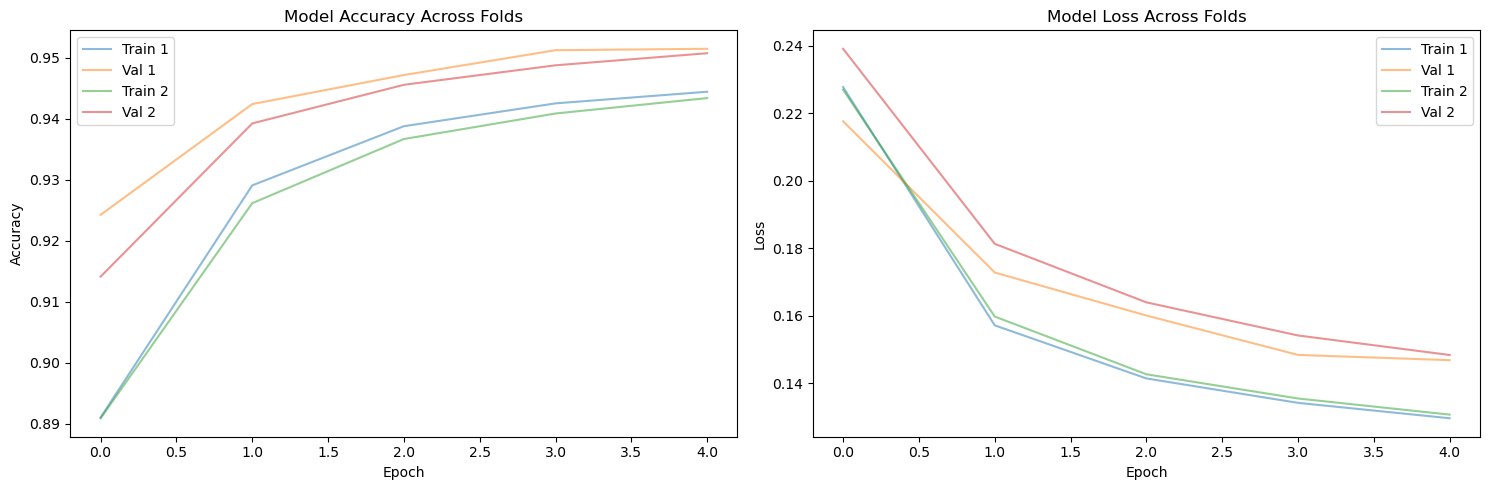


Aggregated Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97   4093498
           1       0.93      0.91      0.92   1426980
           2       0.81      0.96      0.88    290010
           3       0.82      1.00      0.90    208980

    accuracy                           0.95   6019468
   macro avg       0.88      0.96      0.92   6019468
weighted avg       0.95      0.95      0.95   6019468



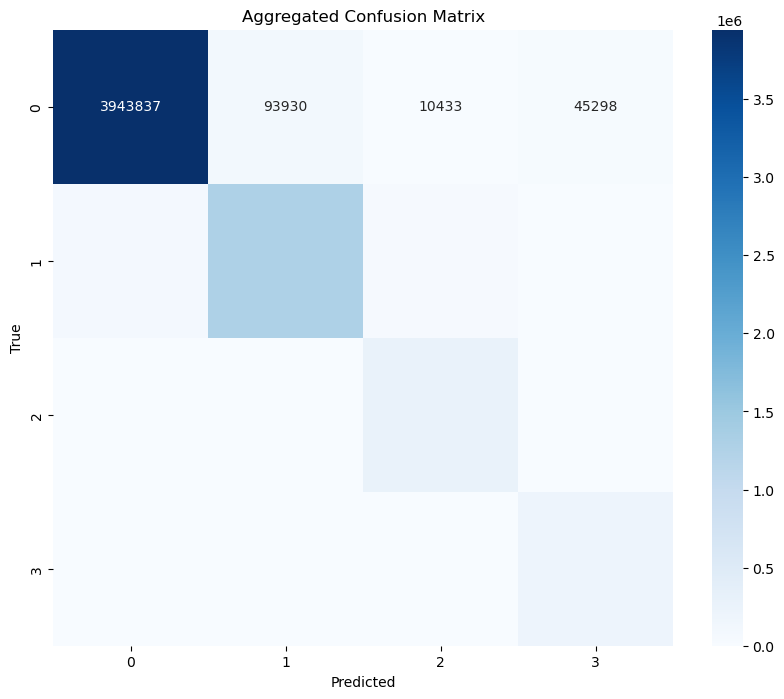

In [29]:
# Print overall results
print("\nCross-validation Results:")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# Plot cross-validation metrics
print("\nPlotting cross-validation metrics...")
plot_cv_metrics(cv_histories)

# Calculate and print aggregated classification report
print("\nAggregated Classification Report:")
y_true = np.concatenate(fold_true_values)
y_pred = np.concatenate(fold_predictions)
print(classification_report(y_true, y_pred))

# Plot aggregated confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Aggregated Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [43]:
def prepare_test_no_drops(df, sequence_length=6, step=2):
    """
    Prepare test sequences for prediction without dropping any rows and without removing any data.
    Each row is included in a sequence, even if it's part of the last sequence for each patient.
    """
    # Sort the dataframe by patient_id and timestamp
    df = df.sort_values(['patient_id', 'timestamp'])
    
    # Select features used during training
    features = ['diastolic_bp', 'systolic_bp', 'heart_rate', 'oxygen_saturation']
    
    # Convert gender to numeric (same as training)
    df['gender_numeric'] = (df['gender'] == 'M').astype(int)
    feature_cols = features + ['gender_numeric']
    
    feature_array = df[feature_cols].values
    
    # Get patient change indices
    patient_ids = df['patient_id'].values
    patient_changes = np.where(patient_ids[1:] != patient_ids[:-1])[0] + 1
    
    sequences = []
    patient_ids_list = []  # To keep track of the corresponding patient IDs for predictions
    
    start_idx = 0
    for end_idx in np.append(patient_changes, len(df)):
        patient_features = feature_array[start_idx:end_idx]
        
        # Handle cases where patient features are fewer than sequence_length
        if len(patient_features) >= sequence_length:
            valid_indices = range(0, len(patient_features) - sequence_length + 1, step)
            
            for i in valid_indices:
                sequences.append(patient_features[i:i + sequence_length])
                patient_ids_list.append(df['patient_id'].iloc[i])  # Store the patient_id for prediction
        else:
            # Handle short sequences: Pad the sequence to the required length
            padded_features = np.pad(patient_features, ((0, sequence_length - len(patient_features)), (0, 0)), mode='constant')
            sequences.append(padded_features)  # Add padded sequence
            patient_ids_list.append(df['patient_id'].iloc[0])  # Store the first patient_id for prediction
        
        start_idx = end_idx
    
    return np.array(sequences), np.array(patient_ids_list)

# Prepare the test sequences (without dropping any rows and padding as needed)
print("Preparing test sequences...")
X_test_sequences, test_ids = prepare_test_no_drops(
    test_df,
    sequence_length=6,
    step=2
)

# Scale the test features using the same scaler from training
X_test_scaled = scaler.transform(X_test_sequences.reshape(-1, X_test_sequences.shape[-1]))
X_test_scaled = X_test_scaled.reshape(X_test_sequences.shape)

# Generate predictions
print("Generating predictions...")
y_pred_prob = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'predicted_label': y_pred_classes
})

# Save predictions to CSV
output_file = 'predictions_lstm.csv'
predictions_df.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")

Preparing test sequences...
Generating predictions...
5078/5078 ━━━━━━━━━━━━━━━━━━━━ 3s 528us/step
Predictions saved to predictions_lstm.csv


In [47]:
test_ids.shape

(162494,)

In [45]:
test_df.shape

(325440, 10)